In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve, auc, roc_curve, average_precision_score
from sklearn.datasets import load_breast_cancer

/home/mustafa/miniconda3/envs/t2/lib/python3.13/site-packages/numpy/_core/getlimits.py:551: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [ ]:
class CustomLogisticRegression:
    def __init__(self, learning_rate=0.01, number_of_epochs=1000,
                 regularization_strength=0.01, regularize=False, scale=False,
                 verbose=False, log_every=100,
                 ):
        self.weights_vector = None                  # weights of features (coefficients). shape(n_features,)
        self.bias = None                            # bias (intercept)
        self.learning_rate = learning_rate          # learning rate
        self.number_of_epochs = number_of_epochs    # number of training epochs
        self.final_loss = None                      # last loss value of the model
        self.loss_history = []                      # all losses generated by the model
        self.regularize = regularize                # should the model add regularization
        self.regularization_strength = regularization_strength  # should the model regularize, how strong the regularization be
        self.scale = scale                          # should the model scale the data before fitting
        self.scaler = None                          # the scaler used to scale the model
        self.verbose = verbose
        self.log_every = log_every

    def _sigmoid(self, z):
        # Activation function to turn the output of the forward propogation (raw values - z) to a probability
        z = np.clip(z, -500, 500)  # Clipping to avoid overflow
        return 1 / (1 + np.exp(-z))
    
    def _log_loss(self, y, y_hat):
        # the cost function of a logistic regression
        epsilon = 1e-10
        mean_loss = -np.mean(y * np.log(y_hat + epsilon) + (1 - y) * np.log(1 - y_hat + epsilon))
        if self.regularize:
            l2_penalty = (self.regularization_strength / 2) * np.sum(self.weights_vector ** 2)
            return mean_loss + l2_penalty
        else:
            return mean_loss
    
    def _forward_propagation(self, X, y):
        '''
            Forward propagation, in simple English, is the process where the model takes the input data,
                applies its current parameters (like weights and bias), and calculates the predicted output step-by-step.
            
            Steps:
                1. Forward propagation takes the input data X, multiplies it by the weights vector, and adds the bias.
                    This produces the raw model output (logits).
                2. It applies the sigmoid function to convert these raw values into probabilities of the output belonging to class 1 or 0.
            Essentially, forward propagation means "feeding" the input through the model to get its prediction.
            In this implementation, it also tracks how wrong the model is by calculating the log loss between the prediction and the actual target.
        

            shape of returned values:
                1. y_hat: (number_of_features,)
                2. bias_derivative: scalar
        '''
        z = X @ self.weights_vector + self.bias  # (n_samples x n_features) @ (n_features,) --> shape(n_samples,)
        y_hat = self._sigmoid(z)  # outputs probability for each row(sample) in X
        loss = self._log_loss(y, y_hat)
        self.loss_history.append(loss)
        return y_hat, loss

    def _back_propagation(self, X, y, y_hat):
        '''
            Backpropagation calculates how to adjust its internal parameters (weights and bias)
            to improve future predictions.

            Steps:
                1. Compute the error (difference between prediction and truth).
                2. Calculate the gradients—i.e., how much each weight and the bias contributed to that error.
                3. These gradients guide the model on how much and in which direction to update each parameter 
                to reduce the prediction error in the next iteration.

            shape of returned values:
                1. weights_derivative: (number_of_features,)
                2. bias_derivative: scalar
        '''
        error = y_hat - y  # shape(n_samples,)
        bias_derivative = np.mean(error)  # bias not affected by regularization
        
        number_of_samples = X.shape[0]
        if self.regularize:
            weights_derivative = (1 / number_of_samples) * X.T @ error  + ( self.regularization_strength * self.weights_vector )  # shape(n_features,)
        else:
            weights_derivative = (1 / number_of_samples) * X.T @ error
        return weights_derivative, bias_derivative 

    def _update(self, weights_derivative, bias_derivative):
        '''
            Updates the model's parameters using the calculated gradients.

            Applies gradient descent by adjusting the weights vector and bias term
            in the opposite direction of their respective gradients, scaled by the learning rate.

            Parameters:
            - weights_derivative (ndarray): Gradient of the loss with respect to the weights. shape: (number_of_features,)
            - bias_derivative (float): Gradient of the loss with respect to the bias (scalar)

            This step helps the model minimize the loss in subsequent iterations.
        '''
        self.weights_vector = self.weights_vector - self.learning_rate * weights_derivative
        self.bias = self.bias - self.learning_rate * bias_derivative
        
    def fit(self, X, y):
        """
            Train the logistic regression model using batch gradient descent.

            Parameters:
            -----------
            X : array-like of shape (n_samples, n_features)
                The input features for training.
            
            y : array-like of shape (n_samples,)
                The target binary labels (0 or 1).
            
            verbose : bool, default=False
                If True, prints training progress and loss every `log_every` epochs.
            
            log_every : int, default=100
                The interval (in epochs) at which to print training progress when verbose is True.

            Returns:
            --------
            self : object
                Fitted model instance with updated weights and bias.

            Notes:
            ------
            - If `scale` parameter is True, the input features are standardized before training.
            - Initializes weights and bias to zero.
            - Uses vectorized operations for efficient computation.
            - Performs gradient descent for `number_of_epochs` iterations.
        """
        if self.scale:  # assumes the split happended before calling fit
            self.scaler = StandardScaler() 
            X = self.scaler.fit_transform(X)

        self.weights_vector = np.zeros(X.shape[1])  # shape(n_features,) because there's only one output per sample. If multiclass, then shape(n_features, k) where k is the number of classes
        self.bias = 0  # single value because there's only one output per sample. If multiclass, then shape(k, ), where k is the number of classes
        for epoch in range(self.number_of_epochs):
            y_hat, loss = self._forward_propogation(X, y)
            weights_derivative, bias_derivative = self._back_propogation(X, y, y_hat)
            self._update(weights_derivative, bias_derivative)

            if self.verbose and (epoch % self.log_every == 0 or epoch == self.number_of_epochs - 1):
                print(f"Epoch {epoch:<5} | Loss: {loss:.5f} | Weights Norm: {np.linalg.norm(self.weights_vector):.5f}")

        self.final_loss = loss
        return self
    
    def predict_probability(self, X):
        if self.scale and self.scaler is not None:
            X = self.scaler.transform(X)
        z = X @ self.weights_vector + self.bias
        return self._sigmoid(z)

    def predict(self, X):
        if self.scale and self.scaler is not None:
            X = self.scaler.transform(X)
        probabilites = self.predict_probability(X)
        return (probabilites >= 0.5).astype(int)

    def inverse_transform(self):
        if self.scale == False or self.scaler is None:
            raise ValueError('Data was not scaled, so it cannot be inverse transformed')
        standard_deviations = self.scaler.scale_
        original_weights = self.weights_vector / standard_deviations
        means = self.scaler.mean_
        original_intercept = self.bias - np.sum(self.weights_vector * means / standard_deviations)
        return original_weights, original_intercept

    def plot_losses(self, ax: plt.Axes = None):
        '''
            Plot losses over the epochs as the model is training
        '''
        if ax == None:
            ax = plt.gca()

        ax.plot(self.loss_history, label=f'Final loss: {self.final_loss:.2f}')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss')
        ax.set_title('Training Loss Over Epochs')
        ax.legend()
        ax.grid(True)

    def plot_precision_recall_curve(self, y_test, prediction_probabilities, ax: plt.Axes = None):
        '''
            The Precision-Recall Curve is a tool to evaluate a classifier—especially useful
            for imbalanced datasets where positive and negative classes are not evenly distributed.
        '''
        precision, recall, _ = precision_recall_curve(y_test, prediction_probabilities)
        average_precision = average_precision_score(y_test, prediction_probabilities)
        
        if ax == None:
            ax = plt.gca()

        ax.plot(recall, precision, label=f'Average Precision: {average_precision:.2f}')
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_title('Precision-Recall Curve')
        ax.legend()
        ax.grid(True)
    
    def plot_roc_area_curve(self, true_values, prediction_probabilities, ax: plt.Axes = None, plot_random_guesses=True):
        '''
            Plot the ROC (Receiver Operating Characteristic) area curve.
        '''
        false_positive_rate, true_positive_rate, _ = roc_curve(true_values, prediction_probabilities)
        auc_value = auc(false_positive_rate, true_positive_rate)

        if ax == None:
            ax = plt.gca()

        ax.plot(false_positive_rate, true_positive_rate, label=f'Model (AUC = {auc_value:.2f})')
        
        if plot_random_guesses:
            ax.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.5)')

        ax.set_xlabel('False Positive Rates')
        ax.set_ylabel('True Positive Rates')
        ax.set_title('ROC area curve')
        ax.legend()
        ax.grid(True)

---
---

In [21]:
data = load_breast_cancer()

features = data.data
target = data.target

X_train, X_test, y_train, y_test  = train_test_split(features, target, test_size=0.3, random_state=100, shuffle=True)

lr_1 = CustomLogisticRegression(learning_rate=0.000005, number_of_epochs=10000).fit(X_train, y_train)
lr_2 = CustomLogisticRegression(learning_rate=0.005, number_of_epochs=10000,
                              regularization_strength=0.001, regularize=True, scale=True).fit(X_train, y_train)

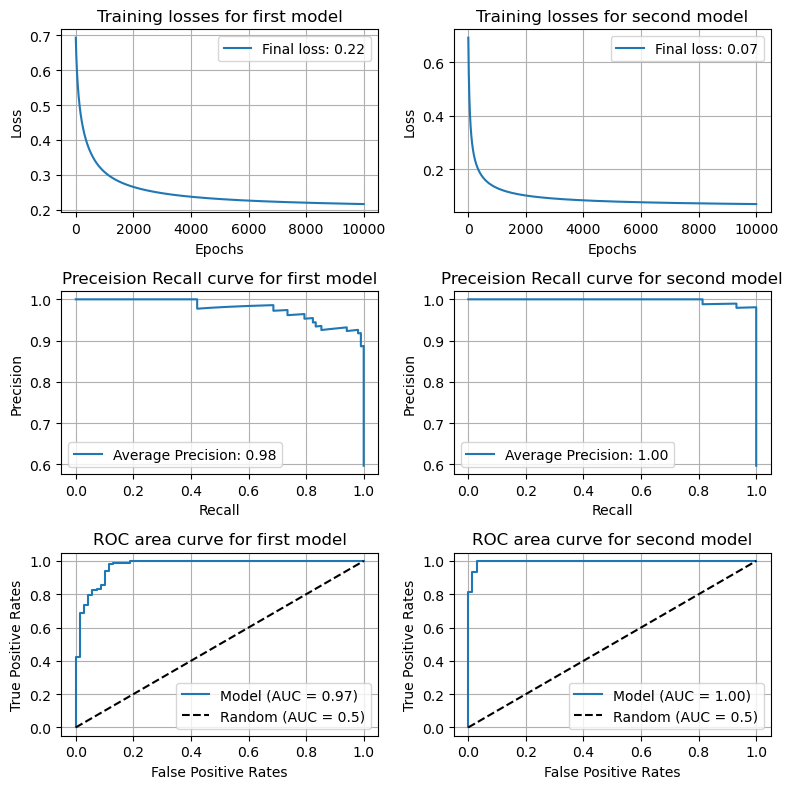

In [17]:
figure, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 8))
axes = axes.flatten()

lr_1.plot_losses(ax=axes[0]); axes[0].set_title('Training losses for first model')
lr_2.plot_losses(ax=axes[1]); axes[1].set_title('Training losses for second model')


predictions_lr_1 =  lr_1.predict_probability(X_test)
predictions_lr_2 = lr_2.predict_probability(X_test)

lr_1.plot_precision_recall_curve(y_test, predictions_lr_1, ax=axes[2]); axes[2].set_title('Preceision Recall curve for first model')
lr_2.plot_precision_recall_curve(y_test, predictions_lr_2, ax=axes[3]); axes[3].set_title('Preceision Recall curve for second model')

lr_1.plot_roc_area_curve(y_test, predictions_lr_1, ax=axes[4]); axes[4].set_title('ROC area curve for first model')
lr_2.plot_roc_area_curve(y_test, predictions_lr_2, ax=axes[5]); axes[5].set_title('ROC area curve for second model')

figure.tight_layout()

In [7]:
preds_1 = lr_1.predict(X_test)
preds_2 = lr_2.predict(X_test)

print('-' * 50)
print(f'F1 score: {f1_score(y_test, preds_1):.2f}')
print(f'Accuracy: {accuracy_score(y_test, preds_1):.2f}')
print('-' * 50)
print(f'F1 score: {f1_score(y_test, preds_2):.2f}')
print(f'Accuracy: {accuracy_score(y_test, preds_2):.2f}')
print('-' * 50)

--------------------------------------------------
F1 score: 0.95
Accuracy: 0.94
--------------------------------------------------
F1 score: 0.61
Accuracy: 0.59
--------------------------------------------------


---
---

In [8]:
X_train, X_test, y_train, y_test  = train_test_split(features, target, test_size=0.3, random_state=100, shuffle=True)

lr_custom_reg_scaled = CustomLogisticRegression(learning_rate=0.01, number_of_epochs=1000,
                              regularization_strength=0.01, regularize=True, 
                              scale=True).fit(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)
# lr_sklearn_scaled = LogisticRegression(max_iter=5000, class_weight='balanced').fit(X_train_scaled, y_train)
# lr_sklearn_scaled = LogisticRegression(max_iter=1000, C=1).fit(X_train_scaled, y_train)
lr_sklearn_scaled = LogisticRegression(
    max_iter=1000, 
    C=1,             
    class_weight=None, 
    penalty='l2', 
    solver='lbfgs'
).fit(X_train_scaled, y_train)

In [9]:
predictions_custom_regularized_scaled = lr_custom_reg_scaled.predict(X_test)
predictions_sklearn_scaled = lr_sklearn_scaled.predict(X_test_scaled)

print('-' * 50)
print(f'F1 score: {f1_score(y_test, predictions_custom_regularized_scaled):.2f}')
print(f'Accuracy: {accuracy_score(y_test, predictions_custom_regularized_scaled):.2f}')
print('-' * 50)
print(f'F1 score: {f1_score(y_test, predictions_sklearn_scaled):.2f}')
print(f'Accuracy: {accuracy_score(y_test, predictions_sklearn_scaled):.2f}')
print('-' * 50)

--------------------------------------------------
F1 score: 0.75
Accuracy: 0.72
--------------------------------------------------
F1 score: 0.97
Accuracy: 0.96
--------------------------------------------------


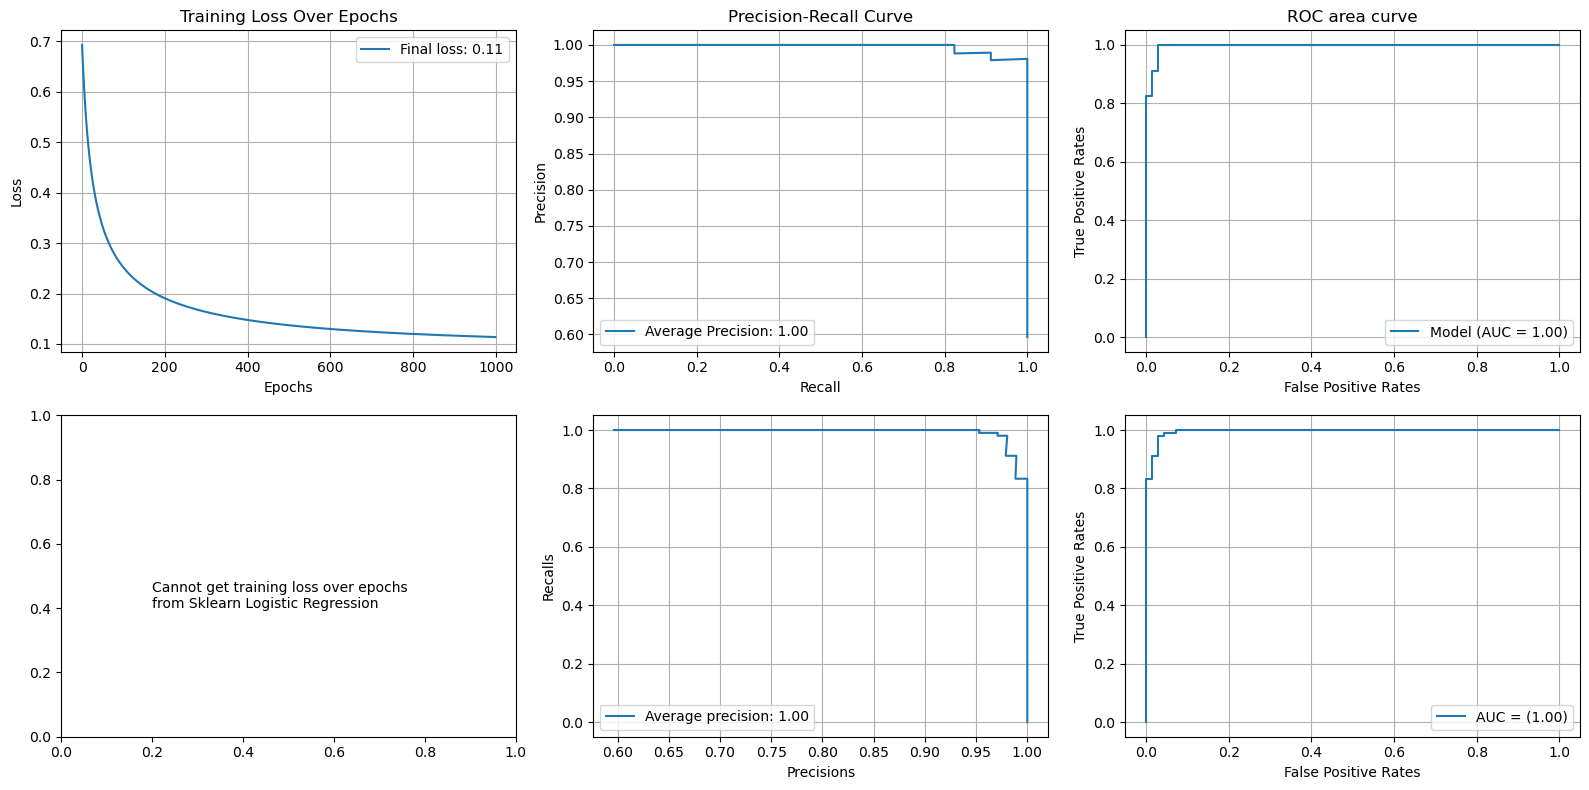

In [10]:
figure, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))
axes = axes.flatten()

# Evalaution plots for CustomLogisticRegression
lr_custom_reg_scaled.plot_losses(ax=axes[0])
lr_custom_reg_scaled.plot_precision_recall_curve(y_test, lr_custom_reg_scaled.predict_probability(X_test), ax=axes[1])
lr_custom_reg_scaled.plot_roc_area_curve(y_test, lr_custom_reg_scaled.predict_probability(X_test), ax=axes[2], plot_random_guesses=False)


# Evaluation plots for Sklearn Logistic Regression

axes[3].text(x= 0.2, y=0.4, s='Cannot get training loss over epochs\nfrom Sklearn Logistic Regression')

predictions_probabilities_sklearn_scaled = lr_sklearn_scaled.predict_proba(X_test_scaled)[:, 1]  # we're only interested in the positive class for the plots

precisions, recalls, _ = precision_recall_curve(y_test, predictions_probabilities_sklearn_scaled)
average_precision = average_precision_score(y_test, predictions_probabilities_sklearn_scaled)
axes[4].plot(precisions, recalls, label=f'Average precision: {average_precision:.2f}')
axes[4].set_xlabel('Precisions')
axes[4].set_ylabel('Recalls')
axes[4].grid(True)
axes[4].legend()

false_positive_rate, true_positive_rate, _ = roc_curve(y_test, predictions_probabilities_sklearn_scaled)
auc_value = auc(false_positive_rate, true_positive_rate)
axes[5].plot(false_positive_rate, true_positive_rate, label=f'AUC = ({auc_value:.2f})')
axes[5].set_xlabel('False Positive Rates'); axes[5].set_ylabel('True Positive Rates'); axes[5].grid(True)
axes[5].legend();

figure.tight_layout()

In [11]:
original_weights, original_intercept = lr_custom_reg_scaled.inverse_transform() 

print('Comparing weights and intercept between custom and sklearn logistic regression')

custom_lr_weights: np.ndarray = original_weights
custom_lr_intercept: float = original_intercept
sklearn_lr_weights, sklearn_lr_intercept = lr_sklearn_scaled.coef_[0], lr_sklearn_scaled.intercept_

weights_df = pd.DataFrame(index=data.feature_names, data={'Custom': np.round(custom_lr_weights, 2), 'Sklearn': np.round(sklearn_lr_weights, 2)})
weights_df.loc['Intercept'] = {'Custom': custom_lr_intercept, 'Sklearn': sklearn_lr_intercept[0]}

print('')
print(weights_df.head())
print('')
print(weights_df.loc['Intercept'])

Comparing weights and intercept between custom and sklearn logistic regression

                 Custom  Sklearn
mean radius       -0.10    -0.26
mean texture      -0.08    -0.52
mean perimeter    -0.01    -0.28
mean area         -0.00    -0.32
mean smoothness  -11.31    -0.26

Custom     17.195145
Sklearn     0.697659
Name: Intercept, dtype: float64


---
---

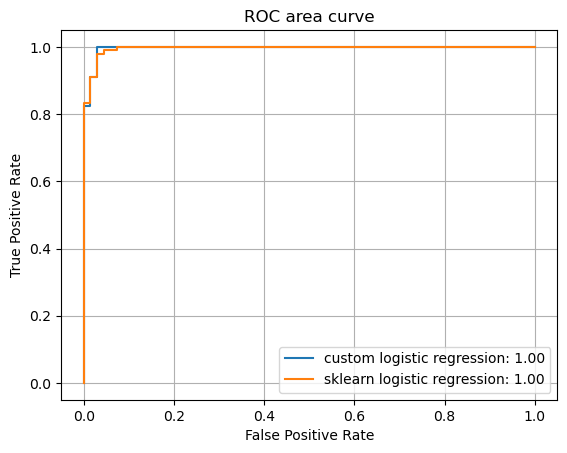

In [12]:
# custom logistic regression roc curve
predictions_prob_custom = lr_custom_reg_scaled.predict_probability(X_test)
fpr_custom, tpr_custom, _ = roc_curve(y_test, predictions_prob_custom)
auc_custom = auc(fpr_custom, tpr_custom)

# sklearn logistic regression roc curve
prediction_prob_sklearn = lr_sklearn_scaled.predict_proba(X_test_scaled)[:, 1]
fpr_sklearn, tpr_sklearn, _ = roc_curve(y_test, prediction_prob_sklearn)
auc_sklearn = auc(fpr_sklearn, tpr_sklearn)

figure, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(fpr_custom, tpr_custom, label=f'custom logistic regression: {auc_custom:.2f}')
ax.plot(fpr_sklearn, tpr_sklearn, label=f'sklearn logistic regression: {auc_sklearn:.2f}')
ax.set_title('ROC area curve')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.grid(True)
ax.legend()

In [13]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(
    loss='log_loss',
    eta0=0.01,         # learning rate
    learning_rate='constant',
    alpha=0.001,        # regularization strength
    penalty='l2',
    max_iter=1,         # only 1 epoch at a time
    warm_start=True,    # keep weights between calls
    random_state=100,
)

# First call needs `classes`
sgd.partial_fit(X_train_scaled, y_train, classes=np.unique(target))

n_epochs = 1000
loss_history = []

for _ in range(n_epochs):
    sgd.partial_fit(X_train_scaled, y_train)
    proba = sgd.predict_proba(X_train_scaled)[:, 1]
    loss = -y_train * np.log(proba + 1e-10) - (1 - y_train) * np.log(1 - proba + 1e-10)
    mean_loss = np.mean(loss)
    loss_history.append(mean_loss)

preds = sgd.predict(X_test_scaled)

print(f'F1 score: {f1_score(y_test, preds):.2f}')
print(f'Accuracy: {accuracy_score(y_test, preds):.2f}')
print('-' * 50)

for colname, weight in zip(data.feature_names[:5], sgd.coef_[0][:5]):
    print(f'{colname}: {weight:.2f}')

F1 score: 0.97
Accuracy: 0.96
--------------------------------------------------
mean radius: -0.05
mean texture: -0.49
mean perimeter: -0.13
mean area: -0.16
mean smoothness: -0.32


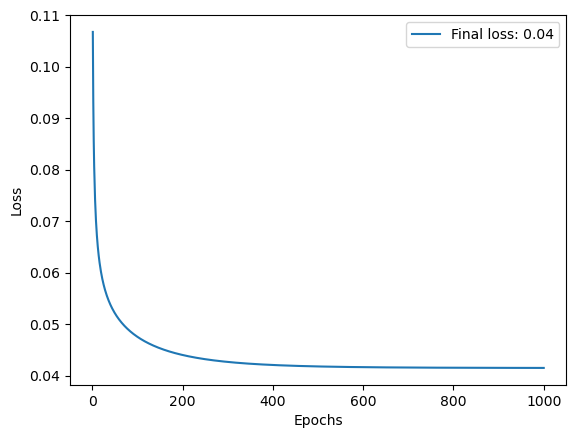

In [14]:
plt.plot(range(1, n_epochs + 1), loss_history, label=f'Final loss: {loss_history[-1]:.2f}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

---
---
---
---